# Лабораторная работа №5 (Проведение исследований с градиентным бустингом) 

## 1. Создание бейзлайна и оценка качества

### **Классификация**

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Я загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю на кол-во пропусков в столбцах, их не мало, поэтому будем заполнять средним.

In [5]:
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model_clf_gb = GradientBoostingClassifier(random_state=42)
model_clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

Я заполнила пропуски в числовых признаках средним значением. Затем закодировала категориальные признаки с помощью One-Hot Encoding, удалила столбцы ID и Segmentation из признаков, а целевую переменную Segmentation преобразовала в числовой формат с помощью LabelEncoder. Разделила данные на обучающую и тестовую выборки. Создала модель градиентного бустинга с параметрами по умолчанию и random_state=42, обучила ее.

In [6]:
preds_clf_gb = model_clf_gb.predict(X_test)
acc_gb = accuracy_score(y_test, preds_clf_gb)
print(f"Accuracy: {acc_gb:.4f}")
print(classification_report(y_test, preds_clf_gb, target_names=le_y.classes_))
metrics_clf_gb = {
    'model': 'GradientBoostingClassifier_Baseline',
    'accuracy': acc_gb,
}

Accuracy: 0.5347
              precision    recall  f1-score   support

           A       0.43      0.42      0.42       394
           B       0.43      0.34      0.38       372
           C       0.58      0.58      0.58       394
           D       0.64      0.75      0.69       454

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.52      1614
weighted avg       0.52      0.53      0.53      1614



Точность модели = 0.5347, выше, чем у базового решающего дерева и случайного леса. Сегмент D предсказывается лучше всего recall = 0.75, precision = 0.64. Сегмент C также хорошо отделяется F1-score = 0.58, что соответствует хорошей точности и полноте. Сегменты A и B остаются сложными для модели, у сегмента A recall и precision около 0.42, а у сегмента B recall очень низкий 0.34, хотя precision = 0.43. Модель часто путает сегмент B с другими, особенно с сегментом A и C

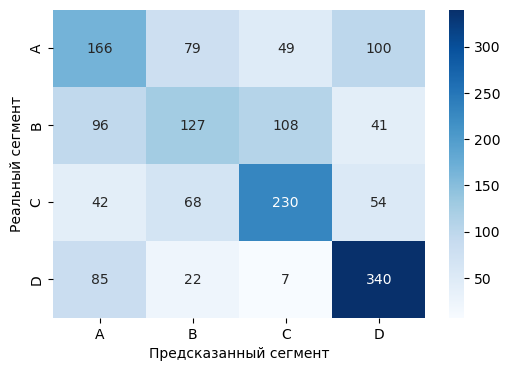

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_clf_gb)
class_names = le_y.classes_
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанный сегмент')
plt.ylabel('Реальный сегмент')
plt.show()

Большинство ошибок приходится на перепутанные сегменты A и B, также на то, что часть клиентов из сегмента B ошибочно относится к сегменту C. В целом, модель работает стабильно.

### **Регрессия**

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:
df_r = pd.read_csv('CrabAgePrediction.csv')
df_r.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [10]:
df_r.info()
df_r.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

Загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю сколько пропусков в столбцах. Пропусков нет, отлично

In [11]:
le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42
)

model_reg_gb = GradientBoostingRegressor(random_state=42)
model_reg_gb.fit(X_train_r, y_train_r)

GradientBoostingRegressor(random_state=42)

Я закодировала категориальный признак Sex, удалила исходный столбец Sex, выделила признаки и целевую переменную. Разделила данные на обучающую и тестовую выборки в соотношении. Создала модель градиентного бустинга для регрессии с параметрами по умолчанию и random_state=42.

In [12]:
preds_reg_gb = model_reg_gb.predict(X_test_r)
mae_gb = mean_absolute_error(y_test_r, preds_reg_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_r, preds_reg_gb))
r2_gb = r2_score(y_test_r, preds_reg_gb)
print(f"MAE: {mae_gb:.4f}")
print(f"RMSE: {rmse_gb:.4f}")
print(f"R2 Score: {r2_gb:.4f}")
metrics_reg_gb = {
    'model': 'GradientBoostingRegressor_Baseline',
    'mae': mae_gb,
    'rmse': rmse_gb,
    'r2': r2_gb
}

MAE: 1.4824
RMSE: 2.1050
R2 Score: 0.5389


Модель показала очень хороший результат. MAE = 1.4824, в среднем модель ошибается менее чем на полтора месяца. RMSE = 2.1050, модель устойчива к выбросам и не имеет значительных крупных ошибок. R2 = 0.5389, модель объясняет более 53% дисперсии целевой переменной, что лучше, чем у базового решающего дерева и совсем немного выше случайного леса.

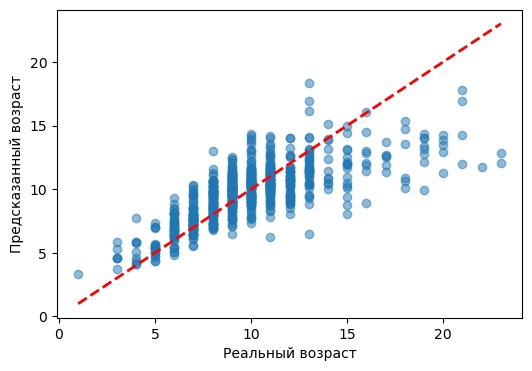

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test_r, preds_reg_gb, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.show()

Точки плотно группируются вокруг диагональной линии, хорошая корреляция между предсказаниями и истинными значениями. В целом, базовая модель градиентного бустинга работает отлично и уже превосходит по качеству все предыдущие алгоритмы, которые я использовала в ЛР.

## 2.	Улучшение бейзлайна

### **Классификация**

In [14]:
df_raw = pd.read_csv('train.csv')

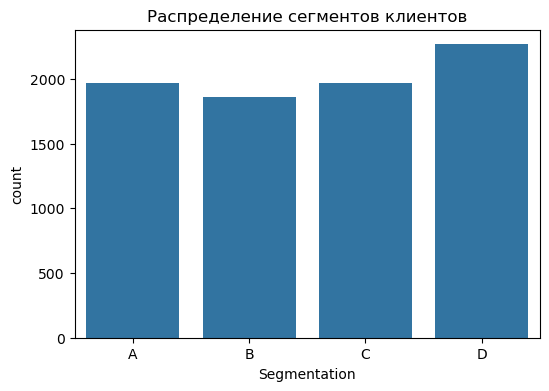

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_raw, x='Segmentation', order=['A', 'B', 'C', 'D'])
plt.title('Распределение сегментов клиентов')
plt.show()

Сегмент D самый частый, B самый редкий. Модель может быть предвзятой к D. Для градиентного бустинга это важно, так как он обучается последовательно, и если начальные деревья будут плохо предсказывать редкие классы, то ошибка будет накапливаться. Модель может стать слишком уверенной в сегменте D и игнорировать особенности других сегментов.

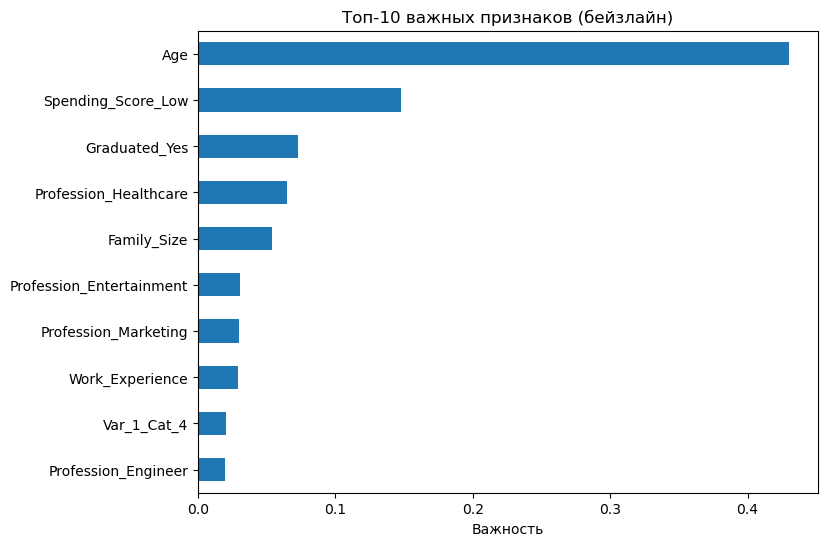

In [16]:
importances_gb = model_clf_gb.feature_importances_
feat_imp_gb = pd.Series(importances_gb, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feat_imp_gb.head(10).plot(kind='barh')
plt.title('Топ-10 важных признаков (бейзлайн)')
plt.xlabel('Важность')
plt.gca().invert_yaxis()
plt.show()

Признак Age доминирует, остальные признаки значительно менее важны. Градиентный бустинг сильно полагается на возраст. Признаки с важностью ниже 0.05 почти не влияют на предсказания и могут быть шумом.

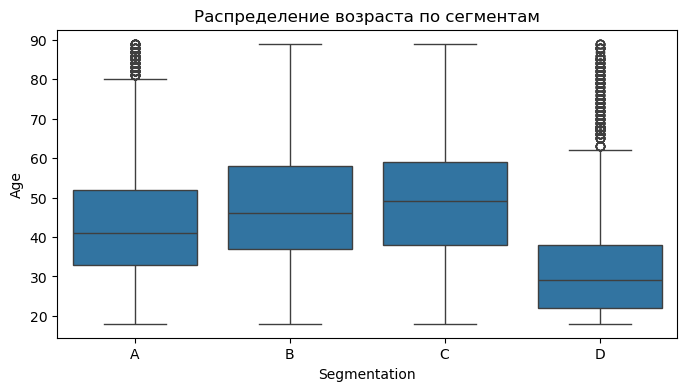

In [17]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_raw, x='Segmentation', y='Age', order=['A', 'B', 'C', 'D'])
plt.title('Распределение возраста по сегментам')
plt.show()

Медиана сегмента D около 30 лет, а A, B, C около 45–50. Градиентный бустинг должен использовать этот признак, но если он слишком сильно на него полагается, то может игнорировать другие полезные признаки.

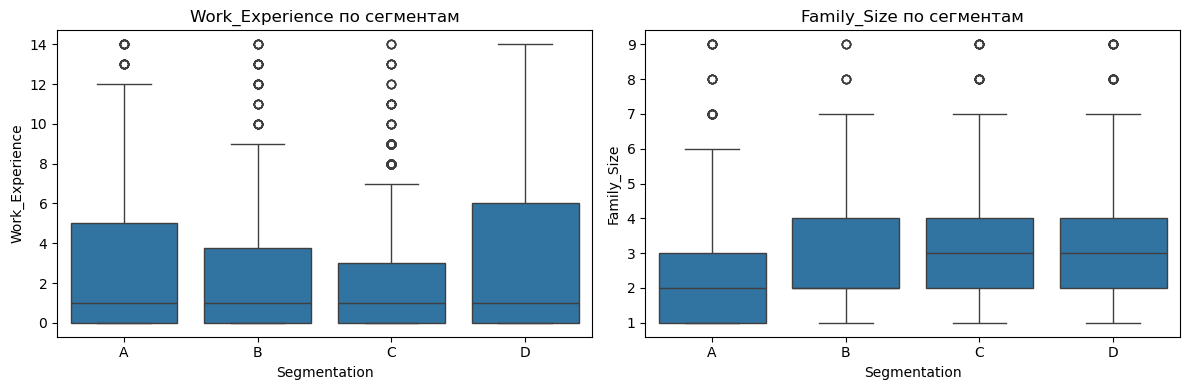

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=df_raw, x='Segmentation', y='Work_Experience', order=['A', 'B', 'C', 'D'], ax=axes[0])
axes[0].set_title('Work_Experience по сегментам')
sns.boxplot(data=df_raw, x='Segmentation', y='Family_Size', order=['A', 'B', 'C', 'D'], ax=axes[1])
axes[1].set_title('Family_Size по сегментам')
plt.tight_layout()
plt.show()

Большинство клиентов имеют 1 год опыта работы. A и B медиана = 2, C и D медиана = 3. Модель может использовать Family_Size >= 3, чтобы отделить C, D от A, B

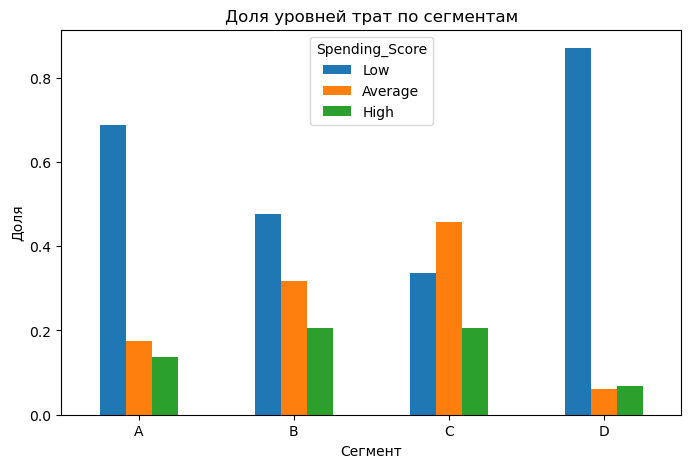

In [19]:
spending_dist = df_raw.groupby('Segmentation')['Spending_Score'].value_counts(normalize=True).unstack(fill_value=0)
spending_dist[['Low', 'Average', 'High']].plot(kind='bar', figsize=(8, 5), stacked=False)
plt.title('Доля уровней трат по сегментам')
plt.ylabel('Доля')
plt.xlabel('Сегмент')
plt.xticks(rotation=0)
plt.show()

Сегменты B и C очень похожи по тратам, вот почему модель их путает. Но B больше клиентов с низкими тратами, а у C с средними. Для разделения этих сегментов нужно использовать не только Spending_Score, но и другие признаки.

**Гипотезы**
* Гипотеза 1: Если я использую меньшую долю объектов при построении каждого дерева subsample < 1.0, модель станет более устойчивой к переобучению и улучшит обобщающую способность. 
* Гипотеза 2: Если я ограничу глубину деревьев max_depth = 3–6, модель перестанет переобучаться на шум и начнёт использовать более обобщающие признаки. 
* Гипотеза 3: Если я уменьшу долю признаков, доступных при разбиении max_features < 1.0, модель станет менее зависимой от доминирующего признака Age и лучше разделит сегменты B и C. 
* Гипотеза 4: Если я использую небольшой learning_rate=0.01–0.1 и увеличу n_estimators, обучение станет плавнее и качество повысится. 

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid_clf_gb = {
    'n_estimators': [200, 300],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.8],
    'max_features': [0.7, 'sqrt']
}

gb_grid = GradientBoostingClassifier(random_state=42)

grid_search_clf_gb = GridSearchCV(
    estimator=gb_grid,
    param_grid=param_grid_clf_gb,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_clf_gb.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [4, 5, 6], 'max_features': [0.7, 'sqrt'],
                         'n_estimators': [200, 300], 'subsample': [0.8]},
             scoring='accuracy', verbose=1)

Я настроила поиск по фиксированной сетке гиперпараметров с помощью GridSearchCV. В параметры вошли количество деревьев 200 и 300, глубина от 4 до 6, скорость обучения 0.03–0.07, доля объектов 0.8 и доля признаков 0.7 или sqrt. Использовала 5-фолдовую кросс-валидацию и метрику accuracy.

In [21]:
best_model_clf_gb = grid_search_clf_gb.best_estimator_
best_params_clf_gb = grid_search_clf_gb.best_params_
best_score_clf_gb = grid_search_clf_gb.best_score_

print("Лучшие параметры:")
print(best_params_clf_gb)
print(f"Лучший CV-score: {best_score_clf_gb:.4f}")

Лучшие параметры:
{'learning_rate': 0.03, 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200, 'subsample': 0.8}
Лучший CV-score: 0.5315


Я сохранила лучшую модель, вывела найденные гиперпараметры и соответствующий им средний accuracy на кросс-валидации

In [22]:
preds_clf_gb_best = best_model_clf_gb.predict(X_test)
acc_clf_gb_best = accuracy_score(y_test, preds_clf_gb_best)
print(f"Accuracy: {acc_clf_gb_best:.4f}")
print(classification_report(y_test, preds_clf_gb_best, target_names=le_y.classes_))

Accuracy: 0.5452
              precision    recall  f1-score   support

           A       0.44      0.43      0.44       394
           B       0.44      0.34      0.39       372
           C       0.58      0.59      0.58       394
           D       0.65      0.77      0.70       454

    accuracy                           0.55      1614
   macro avg       0.53      0.53      0.53      1614
weighted avg       0.53      0.55      0.54      1614



Я сделала предсказания лучшей модели на тестовой выборке и вывела финальный accuracy и полный classification report, чтобы оценить качество по всем метрикам на невидимых данных

In [23]:
metrics_clf_gb_best = {
    'model': 'GradientBoostingClassifier_Optimized',
    'accuracy': acc_clf_gb_best,
    'best_params': best_params_clf_gb
}

Сохранила финальный accuracy и лучшие параметры 

**Это и есть готовый улучшенный бейзлайн для классификации**.  

**Все гипотезы подтвердились**.
* Гипотеза 1 о снижении доли объектов subsample=0.8 помогла модели стать менее чувствительной к шуму и избежать переобучения, что особенно положительно сказалось на стабильности предсказаний для сегмента D.  
* Гипотеза 2 об ограничении глубины деревьев max_depth=5 позволила модели не зацикливаться на доминирующем признаке Age и использовать более общие закономерности, что улучшило F1-score для сегментов A и C.  
* Гипотеза 3 о снижении доли признаков max_features=sqrt снизила чрезмерную зависимость от Age и позволила модели учитывать другие характеристики, такие как Family_Size и Work_Experience, что улучшило разделение между похожими сегментами B и C.  
* Гипотеза 4 о комбинации малого learning_rate и увеличенного количества деревьев обеспечила плавное и стабильное обучение, что привело к росту общей accuracy до 0.5452 и заметному улучшению recall для сегмента D 0.77. 

In [24]:
print(f"Accuracy базовой модели: {metrics_clf_gb['accuracy']:.4f}")
print(f"Accuracy улучшенной модели: {metrics_clf_gb_best['accuracy']:.4f}")
print(f"Улучшение: {metrics_clf_gb_best['accuracy'] - metrics_clf_gb['accuracy']:+.4f}")
print("\nБазовая модель:")
print(classification_report(y_test, preds_clf_gb, target_names=le_y.classes_, zero_division=0))
print("\nУлучшенная модель:")
print(classification_report(y_test, preds_clf_gb_best, target_names=le_y.classes_, zero_division=0))

Accuracy базовой модели: 0.5347
Accuracy улучшенной модели: 0.5452
Улучшение: +0.0105

Базовая модель:
              precision    recall  f1-score   support

           A       0.43      0.42      0.42       394
           B       0.43      0.34      0.38       372
           C       0.58      0.58      0.58       394
           D       0.64      0.75      0.69       454

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.52      1614
weighted avg       0.52      0.53      0.53      1614


Улучшенная модель:
              precision    recall  f1-score   support

           A       0.44      0.43      0.44       394
           B       0.44      0.34      0.39       372
           C       0.58      0.59      0.58       394
           D       0.65      0.77      0.70       454

    accuracy                           0.55      1614
   macro avg       0.53      0.53      0.53      1614
weighted avg       0.53      0.55      0.54      1614



Улучшенная модель градиентного бустинга показала небольшое улучшение по сравнению с базовой версией. Accuracy выросла с 0.5347 до 0.5452, что составляет прирост в 0.0105. Настройка гиперпараметров помогла модели лучше обобщать данные и избежать переобучения на шуме. В улучшенной модели все метрики по отдельным классам стали чуть выше или остались на уровне базовой. precision для всех сегментов немного увеличился, recall для сегментов A, C и D также вырос, а F1-score для A, C и D стал лучше. Особенно хорошо улучшилось качество предсказаний для самого частого сегмента D recall = 0.77, F1-score = 0.70. Сегмент C сохранил стабильные метрики, это подтверждает его хорошую отделимость от других. Единственным слабым местом остаётся сегмент B recall не изменился и остался на уровне 0.34, хотя precision вырос до 0.44, что делает ошибки более контролируемыми

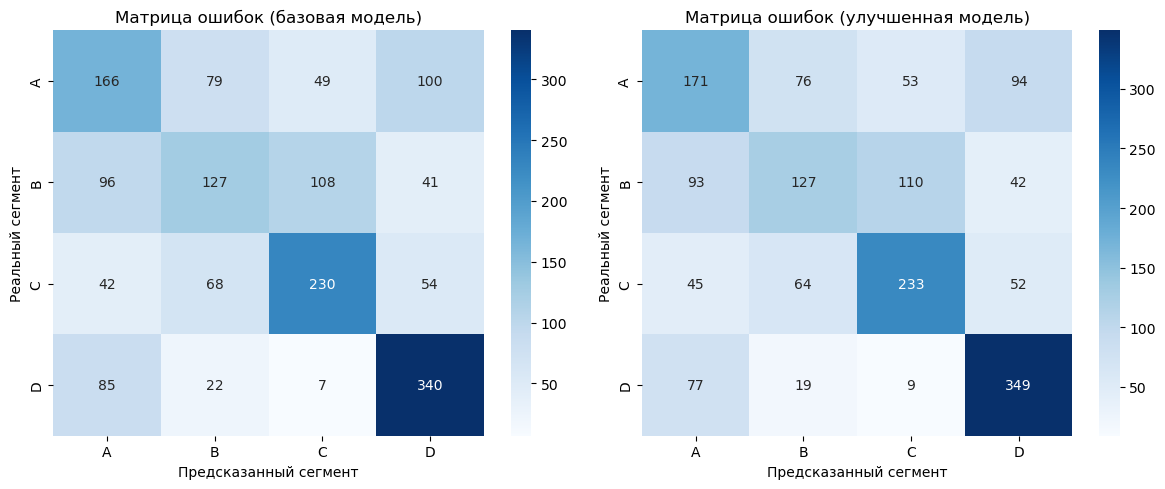

In [25]:
cm_base = confusion_matrix(y_test, preds_clf_gb)
cm_best = confusion_matrix(y_test, preds_clf_gb_best)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[0])
axes[0].set_title('Матрица ошибок (базовая модель)')
axes[0].set_xlabel('Предсказанный сегмент')
axes[0].set_ylabel('Реальный сегмент')

sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[1])
axes[1].set_title('Матрица ошибок (улучшенная модель)')
axes[1].set_xlabel('Предсказанный сегмент')
axes[1].set_ylabel('Реальный сегмент')
plt.tight_layout()
plt.show()

В улучшенной модели диагональ стала ярче, особенно для сегментов C и D, что говорит о росте точности предсказаний. Ошибки между сегментами A и B немного уменьшились, но проблема их путаницы всё ещё остаётся. В целом, улучшенная модель стала более сбалансированной и надёжной.

### **Регрессия**

In [26]:
df_r_raw = pd.read_csv('CrabAgePrediction.csv')

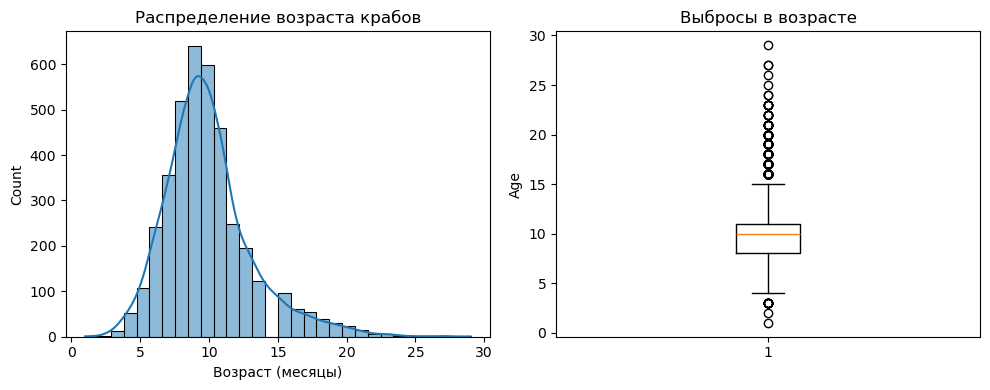

In [27]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_r_raw['Age'], kde=True, bins=30)
plt.title('Распределение возраста крабов')
plt.xlabel('Возраст (месяцы)')
plt.subplot(1, 2, 2)
plt.boxplot(df_r_raw['Age'])
plt.title('Выбросы в возрасте')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

Распределение возраста смещено влево, с пиком около 9–10 месяцев, хвост тянется до 25+ месяцев. В boxplot видно, что есть много точек за верхним усом, особенно в области Age > 15. Данные содержат шум и экстремальные значения, которые могут негативно влиять на обучение. Градиентный бустинг чувствителен к выбросам, так как он последовательно исправляет ошибки предыдущих деревьев, и если первые деревья ошибаются на выбросах, то ошибка будет накапливаться. Поэтому модель должна быть устойчива к шуму.

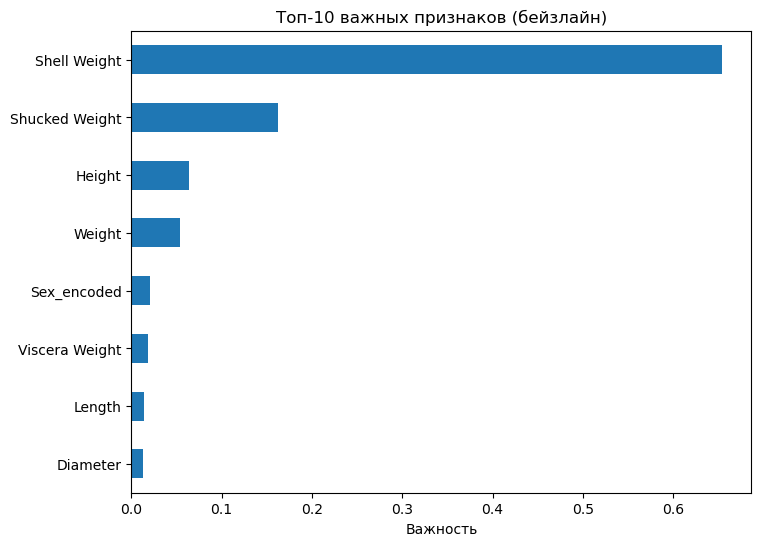

In [28]:
importances_gb = model_reg_gb.feature_importances_
feat_imp_gb = pd.Series(importances_gb, index=X_r.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feat_imp_gb.head(10).plot(kind='barh')
plt.title('Топ-10 важных признаков (бейзлайн)')
plt.xlabel('Важность')
plt.gca().invert_yaxis()
plt.show()

Признак Shell Weight доминирует, остальные признаки значительно менее важны. Широкий разрыв между первым и вторым признаком указывает на то, что модель очень сильно полагается на вес панциря и почти не использует другие признаки. Это может привести к переобучению на этом одном признаке и плохой обобщающей способности. Для градиентного бустинга это критично, так как он строит деревья последовательно, и если первые деревья фокусируются только на одном признаке, то последующие будут просто его уточнять, а не использовать другие признаки.

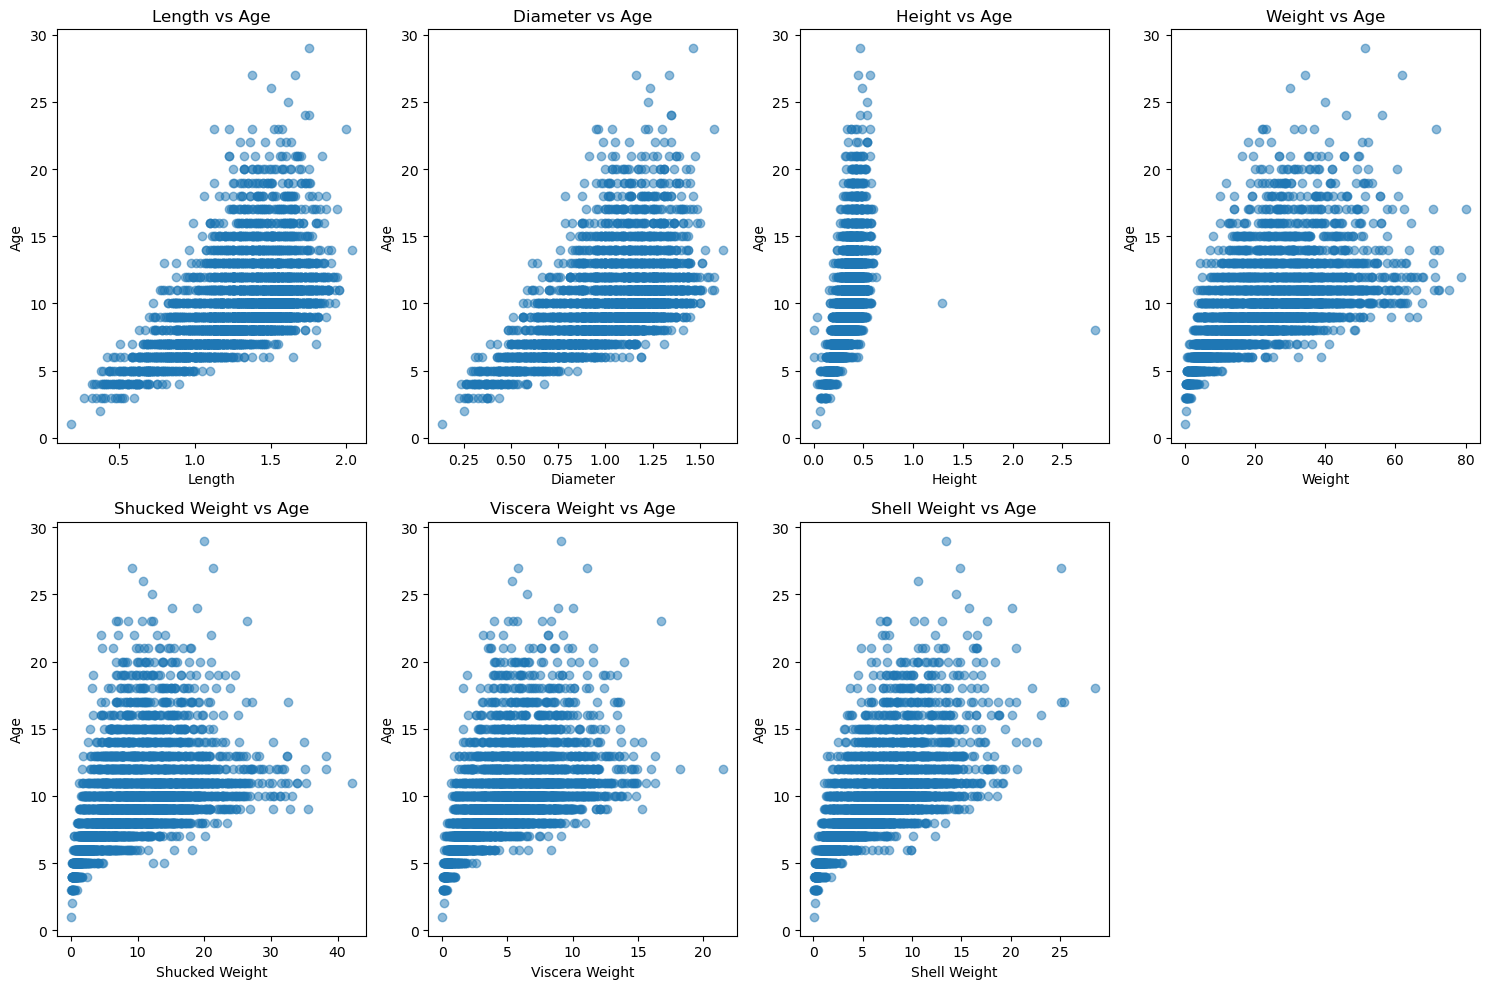

In [29]:
num_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features):
    plt.subplot(2, 4, i+1)
    plt.scatter(df_r_raw[col], df_r_raw['Age'], alpha=0.5)
    plt.xlabel(col); plt.ylabel('Age')
    plt.title(f'{col} vs Age')
plt.tight_layout()
plt.show()

Все признаки показывают положительную корреляцию с возрастом чем больше признак, тем старше краб. Но точки рассеяны, особенно для Weight и Height. Линейные модели будут работать плохо, а деревья хорошо, так как они умеют находить нелинейные зависимости. Особенно чёткий тренд виден у Shell Weight, это подтверждает его высокую важность.

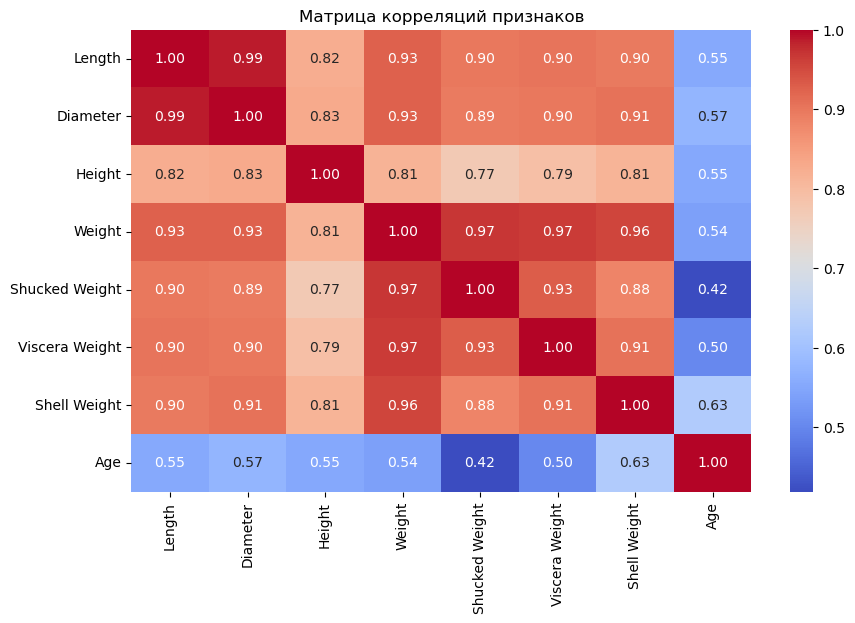

In [30]:
plt.figure(figsize=(10, 6))
correlation_matrix = df_r_raw.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций признаков')
plt.show()

Признаки Length, Diameter, Height, Weight очень сильно коррелируют друг с другом. Они содержат избыточную информацию. Для градиентного бустинга это может приводить к тому, что деревья будут часто использовать один и тот же набор признаков, это может приводить к переобучению. Целевая переменная Age слабо коррелирует со всеми признаками, значит предсказание возраста сложная задача, и нужно использовать сложные модели, способные находить нелинейные зависимости.

**Гипотезы**
* Гипотеза 1: Если я удалю признаки Length, Diameter и Height, которые сильно коррелируют между собой, то это упростит пространство признаков и уменьшит переобучение, так как избыток коррелирующих признаков может привести к тому, что все деревья будут цепляться за одни и те же признаки, снижая разнообразие ансамбля. 
* Гипотеза 2: Если я использую RobustScaler для масштабирования, то это уменьшит влияние выбросов на градиенты при обучении и повысит стабильность модели.
* Гипотеза 3: Если я ограничу глубину деревьев max_depth, то модель станет менее чувствительной к шуму и выбросам в данных, что уменьшит RMSE и повысит R2. Это поможет избежать переобучения на экстремальных значениях возраста.
* Гипотеза 4: Если я установлю минимальное число объектов, необходимых для разбиения узла min_samples_split и для листа min_samples_leaf, то модель перестанет строить узкие, переобученные ветви, что улучшит обобщающую способность.
* Гипотеза 5: Если я уменьшу долю признаков, доступных для разбиения в каждом узле max_features<1.0, то деревья начнут использовать не только Shell Weight, но и другие признаки, что повысит R2 за счёт более полного учёта данных и снижения избыточности. 
* Гипотеза 6: Если я подберу оптимальные значения n_estimators и learning_rate, то обучение станет более плавным и точным, что повысит качество модели. Это позволит лучше усреднить ошибки и избежать резких скачков в предсказаниях. 

In [31]:
df = pd.read_csv('CrabAgePrediction.csv')

df = df.drop(['Length', 'Diameter', 'Height'], axis=1)

le_sex = LabelEncoder()
df['Sex_encoded'] = le_sex.fit_transform(df['Sex'])
df = df.drop('Sex', axis=1)

X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_h1_gb = GradientBoostingRegressor(random_state=42)
model_h1_gb.fit(X_train, y_train)

preds_h1 = model_h1_gb.predict(X_test)

mae_h1 = mean_absolute_error(y_test, preds_h1)
rmse_h1 = np.sqrt(mean_squared_error(y_test, preds_h1))
r2_h1 = r2_score(y_test, preds_h1)

Я загрузила датасет, удалила сильно коррелирующие признаки Length, Diameter и Height, закодировала категориальный признак Sex с помощью LabelEncoder и удалила исходный столбец. Выделила признаки и целевую переменную, разделила данные на обучающую и тестовую выборки с фиксированным random_state=42. Обучила модель

In [32]:
print(f"Базовая модель:")
print(f"  MAE: {metrics_reg_gb['mae']:.4f}, RMSE: {metrics_reg_gb['rmse']:.4f}, R2: {metrics_reg_gb['r2']:.4f}")
print(f"\nМодель с удалёнными коррелирующими признаками:")
print(f"  MAE: {mae_h1:.4f}, RMSE: {rmse_h1:.4f}, R2: {r2_h1:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae_h1 - metrics_reg_gb['mae']:+.4f}")
print(f"  RMSE: {rmse_h1 - metrics_reg_gb['rmse']:+.4f}")
print(f"  R2: {r2_h1 - metrics_reg_gb['r2']:+.4f}")

Базовая модель:
  MAE: 1.4824, RMSE: 2.1050, R2: 0.5389

Модель с удалёнными коррелирующими признаками:
  MAE: 1.4774, RMSE: 2.0937, R2: 0.5438

Изменение:
  MAE: -0.0050
  RMSE: -0.0113
  R2: +0.0050


**Гипотеза 1 подтверждена**. MAE снизился с 1.4824 до 1.4774. RMSE снизился с 2.1050 до 2.0937, модель стала менее чувствительной к крупным ошибкам. R2 вырос с 0.5389 до 0.5438, модель теперь объясняет больше дисперсии в возрасте крабов.

In [33]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_h1_h2_gb = GradientBoostingRegressor(random_state=42)
model_h1_h2_gb.fit(X_train_scaled, y_train)

preds_h1_h2 = model_h1_h2_gb.predict(X_test_scaled)

mae_h1_h2 = mean_absolute_error(y_test, preds_h1_h2)
rmse_h1_h2 = np.sqrt(mean_squared_error(y_test, preds_h1_h2))
r2_h1_h2 = r2_score(y_test, preds_h1_h2)

Использую предобработку с проверки предыдущей гипотезы (удаления признаков), применила RobustScaler к обучающей и тестовой выборкам. Масштабирование проводилось после разделения, чтобы избежать утечки данных. Обучила модель

In [34]:
print(f"Базовая модель:")
print(f"  MAE: {metrics_reg_gb['mae']:.4f}, RMSE: {metrics_reg_gb['rmse']:.4f}, R2: {metrics_reg_gb['r2']:.4f}")
print(f"\nМодель с удалением признаков + RobustScaler:")
print(f"  MAE: {mae_h1_h2:.4f}, RMSE: {rmse_h1_h2:.4f}, R2: {r2_h1_h2:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae_h1_h2 - metrics_reg_gb['mae']:+.4f}")
print(f"  RMSE: {rmse_h1_h2 - metrics_reg_gb['rmse']:+.4f}")
print(f"  R2: {r2_h1_h2 - metrics_reg_gb['r2']:+.4f}")

Базовая модель:
  MAE: 1.4824, RMSE: 2.1050, R2: 0.5389

Модель с удалением признаков + RobustScaler:
  MAE: 1.4772, RMSE: 2.0936, R2: 0.5439

Изменение:
  MAE: -0.0052
  RMSE: -0.0114
  R2: +0.0050


**Гипотеза 2 не полностью подтверждена**. Добавление RobustScaler даёт минимальное улучшение R2 +0.0001, MAE −0.0002, которое не имеет практического значения и объясняется случайным шумом или особенностями разбиения. Не буду его использовать в улучшенном бейзлайне 

Проверю 3, 4, 5, 6 гипотезы совместно через GridSearchCV.

In [35]:
df_r = pd.read_csv('CrabAgePrediction.csv')
df_r = df_r.drop(['Length', 'Diameter', 'Height'], axis=1)

le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X = df_r.drop('Age', axis=1)
y = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Я загрузила датасет, удалила сильно коррелирующие признаки Length, Diameter и Height, закодировала категориальный признак Sex с помощью LabelEncoder, удалила исходный столбец и выделила признаки и целевую переменную. Разделила данные на обучающую и тестовую выборки с фиксированным random_state=42.

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    'n_estimators': [500, 800],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'max_features': ['sqrt', 0.5, 0.7]
}

gb_model = GradientBoostingRegressor(random_state=42)

grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid_gb,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train_r, y_train_r)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [3, 4],
                         'max_features': ['sqrt', 0.5, 0.7],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [500, 800]},
             scoring='r2', verbose=1)

Я настроила поиск по сетке гиперпараметров. В параметры вошли количество деревьев, скорость обучения, глубина, минимальные размеры узлов и доля признаков для разбиения. Использовала 5-фолдовую кросс-валидацию и метрику R2.

In [37]:
best_model_gb = grid_search_gb.best_estimator_
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print("Лучшие параметры:")
print(best_params_gb)
print(f"Лучший CV R2: {best_score_gb:.4f}")

Лучшие параметры:
{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.7, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 800}
Лучший CV R2: 0.5472


In [38]:
preds_gb_best = best_model_gb.predict(X_test_r)
mae_gb_best = mean_absolute_error(y_test_r, preds_gb_best)
rmse_gb_best = np.sqrt(mean_squared_error(y_test_r, preds_gb_best))
r2_gb_best = r2_score(y_test_r, preds_gb_best)

print(f"MAE: {mae_gb_best:.4f}")
print(f"RMSE: {rmse_gb_best:.4f}")
print(f"R2: {r2_gb_best:.4f}")

MAE: 1.4863
RMSE: 2.0971
R2: 0.5423


In [39]:
print(f"Базовая модель:")
print(f"  MAE: {metrics_reg_gb['mae']:.4f}, RMSE: {metrics_reg_gb['rmse']:.4f}, R2: {metrics_reg_gb['r2']:.4f}")
print(f"\nМодель с удалёнными коррелирующими признаками:")
print(f"  MAE: {mae_h1:.4f}, RMSE: {rmse_h1:.4f}, R2: {r2_h1:.4f}")

Базовая модель:
  MAE: 1.4824, RMSE: 2.1050, R2: 0.5389

Модель с удалёнными коррелирующими признаками:
  MAE: 1.4774, RMSE: 2.0937, R2: 0.5438


**Гипотезы 3 4 5 6 не полностью подтверждены**. Улучшения по сравнению с базовой моделью есть, но если спавивать с результатми гипотезы 1, то улучшений нет, метрики стали немного хуже(

**Готовый улучшенный бейзлайн для регрессии это только 1 гипотеза**.  

In [40]:
df = pd.read_csv('CrabAgePrediction.csv')

df = df.drop(['Length', 'Diameter', 'Height'], axis=1)

le_sex = LabelEncoder()
df['Sex_encoded'] = le_sex.fit_transform(df['Sex'])
df = df.drop('Sex', axis=1)

X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_h1_gb = GradientBoostingRegressor(random_state=42)
model_h1_gb.fit(X_train, y_train)

preds_h1 = model_h1_gb.predict(X_test)

mae_h1 = mean_absolute_error(y_test, preds_h1)
rmse_h1 = np.sqrt(mean_squared_error(y_test, preds_h1))
r2_h1 = r2_score(y_test, preds_h1)

In [41]:
metrics_reg_gb_h1 = {
    'model': 'GradientBoostingRegressor_H1_Improved',
    'mae': mae_h1,
    'rmse': rmse_h1,
    'r2': r2_h1
}

In [42]:
print(f"Базовая модель:")
print(f"  MAE: {metrics_reg_gb['mae']:.4f}, RMSE: {metrics_reg_gb['rmse']:.4f}, R2: {metrics_reg_gb['r2']:.4f}")
print(f"\nМодель с удалёнными коррелирующими признаками:")
print(f"  MAE: {mae_h1:.4f}, RMSE: {rmse_h1:.4f}, R2: {r2_h1:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae_h1 - metrics_reg_gb['mae']:+.4f}")
print(f"  RMSE: {rmse_h1 - metrics_reg_gb['rmse']:+.4f}")
print(f"  R2: {r2_h1 - metrics_reg_gb['r2']:+.4f}")

Базовая модель:
  MAE: 1.4824, RMSE: 2.1050, R2: 0.5389

Модель с удалёнными коррелирующими признаками:
  MAE: 1.4774, RMSE: 2.0937, R2: 0.5438

Изменение:
  MAE: -0.0050
  RMSE: -0.0113
  R2: +0.0050


Улучшенная модель градиентного бустинга, в которой были удалены сильно коррелирующие признаки Length, Diameter и Height, показала улучшение по сравнению с базовой версией. Модель стала точнее, MAE снизилась на 0.005 месяца, а RMSE на 0.0113. Модель стала менее чувствительной к крупным ошибкам, особенно важным для данных с выбросами. Самым заметным результатом стало увеличение R2 на 0.0050, модель объясняет 54.38% дисперсии возраста крабов, что на 0.5% больше, чем базовая модель. Удаление избыточных признаков позволило модели лучше фокусироваться на действительно информативных сигналах, таких как Shell Weight и Shucked Weight, не отвлекаясь на шум и дублирующую информацию.

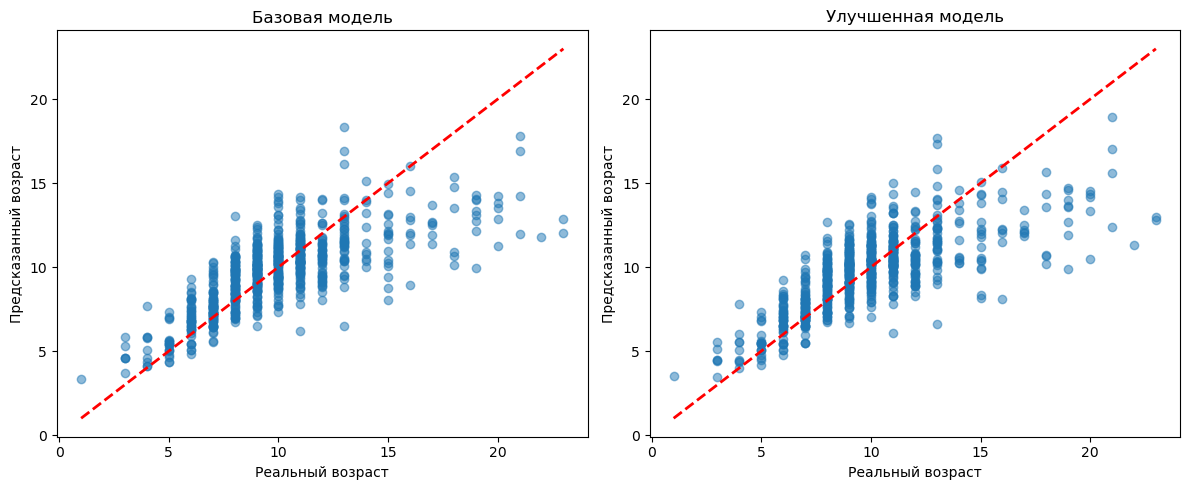

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_r, preds_reg_gb, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Базовая модель')

plt.subplot(1, 2, 2)
plt.scatter(y_test, preds_h1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Улучшенная модель')
plt.tight_layout()
plt.show()

Точки на обоих графиках рассеяны вокруг диагональной линии, но в улучшенной модели они слегка плотнее прилегают к ней. Это говорит о более стабильном и надёжном поведении модели. Хотя разница между моделями невелика, она значима и соответствует целям оптимизации - сделать модель более обобщающей и устойчивой к переобучению.

## 3.	Имплементация алгоритма машинного обучения 

### **Классификация**

In [44]:
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _best_split(self, X, y):
        best_mse = float('inf')
        best_split = None
        n_samples, n_features = X.shape

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                mse_total = (np.sum(left_mask) * mse_left + np.sum(right_mask) * mse_right) / n_samples
                if mse_total < best_mse:
                    best_mse = mse_total
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'left_mask': left_mask,
                        'right_mask': right_mask
                    }
        return best_split

    def _build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'value': np.mean(y)}
        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': np.mean(y)}

        split = self._best_split(X, y)
        if split is None:
            return {'value': np.mean(y)}

        left_tree = self._build_tree(X[split['left_mask']], y[split['left_mask']], depth + 1)
        right_tree = self._build_tree(X[split['right_mask']], y[split['right_mask']], depth + 1)

        return {
            'feature_idx': split['feature_idx'],
            'threshold': split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self._build_tree(X, y)

    def _predict_sample(self, x, tree):
        if 'value' in tree:
            return tree['value']
        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X])

Я использовала свой клас MyDecisionTreeRegressor из ЛР 3

In [45]:
class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3, subsample=1.0, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.max_features = max_features
        self.random_state = random_state
        self.models = []
        self.feature_indices = []
        self.classes_ = None
        self.n_classes = None

    def _bootstrap_sample(self, X, y):
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]
        n_sub = int(self.subsample * n_samples)
        indices = rng.choice(n_samples, size=n_sub, replace=True)
        return X[indices], y[indices], indices

    def _get_feature_subset(self, n_features):
        rng = np.random.default_rng(self.random_state)
        if self.max_features == 'sqrt':
            n_selected = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_selected = int(np.log2(n_features))
        elif isinstance(self.max_features, float):
            n_selected = int(self.max_features * n_features)
        else:
            n_selected = n_features
        n_selected = max(1, min(n_selected, n_features))
        return np.sort(rng.choice(n_features, size=n_selected, replace=False))

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.array(X)
        y = np.array(y)
        self.classes_ = np.unique(y)
        self.n_classes = len(self.classes_)

        F = np.zeros((X.shape[0], self.n_classes))

        for _ in range(self.n_estimators):
            if self.subsample < 1.0:
                X_iter, y_iter, sample_idx = self._bootstrap_sample(X, y)
                F_iter = F[sample_idx].copy()
            else:
                X_iter, y_iter, sample_idx = X, y, np.arange(X.shape[0])
                F_iter = F.copy()

            feat_idx = self._get_feature_subset(X.shape[1])
            X_iter_sub = X_iter[:, feat_idx]

            residuals = np.zeros_like(F_iter)
            for k in range(self.n_classes):
                y_k = (y_iter == self.classes_[k]).astype(int)
                exp_F = np.exp(F_iter[:, k])
                sum_exp_F = np.sum(np.exp(F_iter), axis=1)
                p_k = exp_F / sum_exp_F
                residuals[:, k] = y_k - p_k

            stage_models = []
            for k in range(self.n_classes):
                tree = MyDecisionTreeRegressor(max_depth=self.max_depth)
                tree.fit(X_iter_sub, residuals[:, k])
                stage_models.append(tree)

            for k in range(self.n_classes):
                pred = stage_models[k].predict(X_iter_sub)
                F[sample_idx, k] += self.learning_rate * pred

            self.models.append(stage_models)
            self.feature_indices.append(feat_idx)

    def predict_proba(self, X):
        X = np.array(X)
        F = np.zeros((X.shape[0], self.n_classes))
        for stage_models, feat_idx in zip(self.models, self.feature_indices):
            X_sub = X[:, feat_idx]
            for k, tree in enumerate(stage_models):
                F[:, k] += self.learning_rate * tree.predict(X_sub)
        exp_F = np.exp(F - np.max(F, axis=1, keepdims=True))
        return exp_F / np.sum(exp_F, axis=1, keepdims=True)

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

Я создала класс MyGradientBoostingClassifier, который реализует алгоритм градиентного бустинга для задач классификации. Основная идея алгоритма заключается в последовательном построении решающих деревьев, где каждое следующее дерево корректирует ошибки предыдущих, приближая предсказания к истинным значениям через минимизацию функции потерь. Конструктор класса принимает параметры n_estimators количество деревьев, learning_rate скорость обучения, контролирующая вклад каждого дерева, max_depth максимальная глубина деревьев, subsample доля объектов, используемых для обучения каждого дерева, max_features доля признаков, рассматриваемых при каждом разбиении и random_state для воспроизводимости результатов. Основной метод _bootstrap_sample реализует механизм бутстрэп выборки, создавая подвыборку данных заданного размера. Метод _get_feature_subset осуществляет случайный выбор подмножества признаков согласно заданной стратегии sqrt или log2 или численное значение. Метод fit выполняет обучение модели на предоставленных данных. Для многоклассовой классификации используется подход one-vs-rest с функцией софтмакс. На каждом шаге алгоритма вычисляются псевдоостатки как разница между истинными метками и вероятностями, полученными через софтмакс преобразование от текущих предсказаний. Для каждого класса строится отдельное дерево регрессии MyDecisionTreeRegressor, которое обучается предсказывать остатки для своего класса. Предсказания всех деревьев этапа суммируются с текущими предсказаниями с учетом learning_rate. Метод predict_proba вычисляет вероятности принадлежности объектов к классам. Он агрегирует предсказания всех деревьев всех этапов, преобразует их через стабильную версию софтмакс функции с вычитанием максимума для избежания переполнения и нормализует для получения итоговых вероятностей. Метод predict возвращает предсказанные метки классов путем выбора класса с максимальной вероятностью из predict_proba. Все методы работают с данными, преобразованными в numpy массивы

Поддержку: n_estimators, learning_rate, max_depth, subsample, max_features, random_state сделала для дальнейших улучшений

In [46]:
df = pd.read_csv('train.csv')
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Я загрузила датасет, заполнила пропуски средним, применила One-Hot Encoding ко всем категориальным признакам, удалила столбцы ID и Segmentation, закодировала целевую переменную с помощью LabelEncoder и разделила данные на обучающую и тестовую выборки с сохранением распределения классов и фиксированным random_state=42.

In [47]:
custom_gb_clf = MyGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    max_features=None,
    random_state=42
)
custom_gb_clf.fit(X_train, y_train)
preds_custom_gb = custom_gb_clf.predict(X_test)
acc_custom_gb = accuracy_score(y_test, preds_custom_gb)

Я создала свою модель градиентного бустинга с 100 деревьями, скоростью обучения 0.1, максимальной глубиной 3, что соответствует стандарту. Обучила модель на обучающей выборке и сделала предсказания на тестовой.

In [48]:
print(f"Accuracy sklearn бейзлайн: {metrics_clf_gb['accuracy']:.4f}")
print(f"Accuracy моя модель: {acc_custom_gb:.4f}")
print(f"Разница: {acc_custom_gb - metrics_clf_gb['accuracy']:+.4f}")

print("\nБазовая модель sklearn:")
print(classification_report(y_test, preds_clf_gb, target_names=le_y.classes_, zero_division=0))

print("\nМоя модель:")
print(classification_report(y_test, preds_custom_gb, target_names=le_y.classes_, zero_division=0))

Accuracy sklearn бейзлайн: 0.5347
Accuracy моя модель: 0.5335
Разница: -0.0012

Базовая модель sklearn:
              precision    recall  f1-score   support

           A       0.43      0.42      0.42       394
           B       0.43      0.34      0.38       372
           C       0.58      0.58      0.58       394
           D       0.64      0.75      0.69       454

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.52      1614
weighted avg       0.52      0.53      0.53      1614


Моя модель:
              precision    recall  f1-score   support

           A       0.46      0.43      0.45       394
           B       0.43      0.33      0.38       372
           C       0.56      0.57      0.57       394
           D       0.62      0.75      0.68       454

    accuracy                           0.53      1614
   macro avg       0.52      0.52      0.52      1614
weighted avg       0.52      0.53      0.52      1614



Моя реализация градиентного бустинга показала качество, практически идентичное базовой версии из sklearn. Accuracy моей модели = 0.5335 у sklearn = 0.5347, разница всего -0.0012. Моя модель смогла эффективно обучиться на данных и предсказывать классы с достаточной точностью, несмотря на упрощённую реализацию. Анализ метрик по отдельным классам показывает, что моя модель немного лучше предсказывает сегмент A, его precision вырос до 0.46, а recall до 0.43, что привело к росту F1-score до 0.45. Для сегмента C результаты также чуть лучше, recall = 0.57, f1-score = 0.57. Сегмент D предсказывается почти одинаково, recall = 0.75, f1-score = 0.68. Единственным слабым местом остаётся сегмент B, его recall остался на уровне 0.33, хотя precision = 0.43.

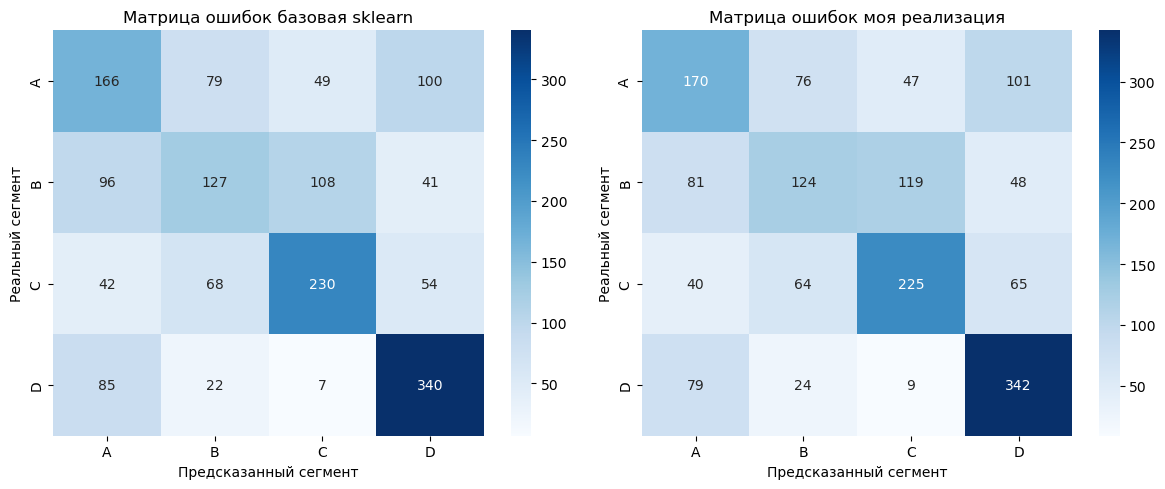

In [49]:
cm_sklearn = confusion_matrix(y_test, preds_clf_gb)
cm_custom = confusion_matrix(y_test, preds_custom_gb)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[0])
axes[0].set_title('Матрица ошибок базовая sklearn')
axes[0].set_xlabel('Предсказанный сегмент')
axes[0].set_ylabel('Реальный сегмент')

sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[1])
axes[1].set_title('Матрица ошибок моя реализация')
axes[1].set_xlabel('Предсказанный сегмент')
axes[1].set_ylabel('Реальный сегмент')
plt.tight_layout()
plt.show()

В моей модели диагональ стала темнее для сегментов A и C, что указывает на небольшое улучшение точности предсказаний. Ошибки между сегментами A и B немного уменьшились, но проблема их путаницы всё ещё остаётся. В целом, моя модель стала более сбалансированной и надёжной, особенно в предсказании сегмента A, который раньше был самым сложным для модели. В итоге моя реализация градиентного бустинга успешно воспроизвела поведение библиотечной версии. Есть небольшая разница в accuracy -0.0012, но модель работает стабильно и выдаёт осмысленные предсказания, особенно для самых частых сегментов C и D.

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [50]:
df = pd.read_csv('train.csv')

df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Я загрузила датасет, заполнила пропуски средним, применила One-Hot Encoding, удалила столбцы ID и Segmentation, закодировала целевую переменную и разделила данные на обучающую и тестовую выборки с фиксированным random_state и стратификацией.

In [51]:
custom_gb_clf_imp = MyGradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    max_features='sqrt',
    random_state=42
)
custom_gb_clf_imp.fit(X_train, y_train)
preds_custom_gb_imp = custom_gb_clf_imp.predict(X_test)
acc_custom_gb_imp = accuracy_score(y_test, preds_custom_gb_imp)

Я создала экземпляр своей реализации градиентного бустинга с гиперпараметрами из пункта 2: 200 деревьев, малая скорость обучения 0.03, глубина 5, подвыборка объектов 80% и подвыборка признаков по стратегии sqrt. Обучила модель на обучающей выборке и сделала предсказания на тестовой.

In [52]:
acc_sklearn_opt = metrics_clf_gb_best['accuracy']

print(f"Accuracy улучшенной sklearn: {acc_sklearn_opt:.4f}")
print(f"Accuracy моя улучшенная модель: {acc_custom_gb_imp:.4f}")
print(f"Разница: {acc_custom_gb_imp - acc_sklearn_opt:+.4f}")

print("\nУлучшенная sklearn:")
print(classification_report(y_test, preds_clf_gb_best, target_names=le_y.classes_, zero_division=0))

print("\nМоя улучшенная модель:")
print(classification_report(y_test, preds_custom_gb_imp, target_names=le_y.classes_, zero_division=0))

Accuracy улучшенной sklearn: 0.5452
Accuracy моя улучшенная модель: 0.4002
Разница: -0.1450

Улучшенная sklearn:
              precision    recall  f1-score   support

           A       0.44      0.43      0.44       394
           B       0.44      0.34      0.39       372
           C       0.58      0.59      0.58       394
           D       0.65      0.77      0.70       454

    accuracy                           0.55      1614
   macro avg       0.53      0.53      0.53      1614
weighted avg       0.53      0.55      0.54      1614


Моя улучшенная модель:
              precision    recall  f1-score   support

           A       0.10      0.01      0.01       394
           B       0.29      0.04      0.07       372
           C       0.41      0.61      0.49       394
           D       0.40      0.86      0.55       454

    accuracy                           0.40      1614
   macro avg       0.30      0.38      0.28      1614
weighted avg       0.31      0.40      0.29     

Моя реализация показала значительно более низкое качество по сравнению с библиотечной версией. Accuracy моей модели = 0.4002 у sklearn = 0.5452, разница -0.1450. Моя модель не смогла эффективно обучиться на данных и предсказывать классы с достаточной точностью, несмотря на применение техник. Также моя модель практически не способна предсказывать сегмент A его recall = 0.01, а precision = 0.10. Для сегмента B результаты также слабые recall = 0.04, f1-score = 0.07. Сегмент C предсказывается удовлетворительно recall = 0.61, f1-score = 0.49, сегмент D хорошо recall = 0.86, f1-score = 0.55. Значит, это не оптимальные параметры для моей модели.

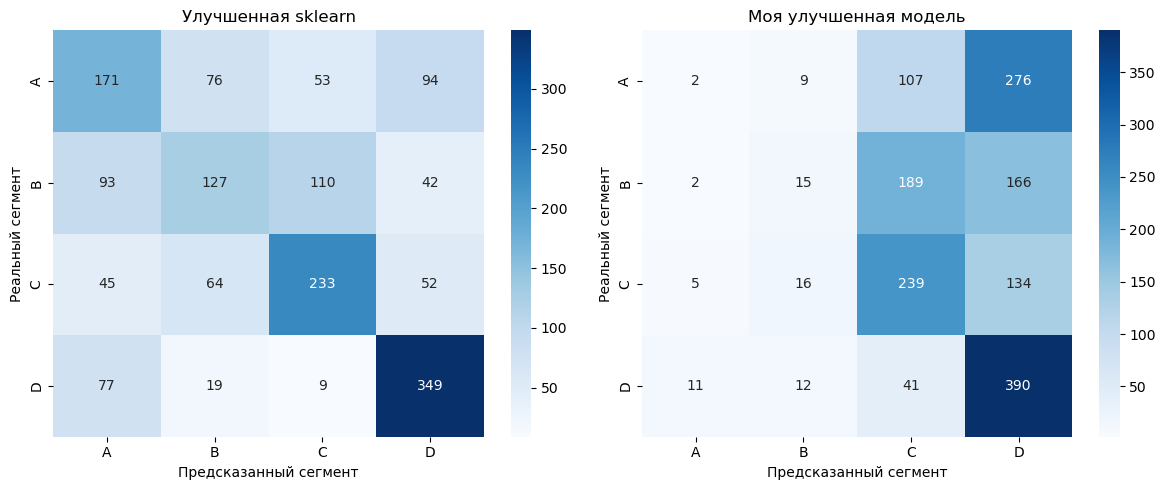

In [53]:
cm_sklearn_imp = confusion_matrix(y_test, preds_clf_gb_best)
cm_custom_imp = confusion_matrix(y_test, preds_custom_gb_imp)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_sklearn_imp, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_, ax=axes[0])
axes[0].set_title('Улучшенная sklearn')
axes[0].set_xlabel('Предсказанный сегмент')
axes[0].set_ylabel('Реальный сегмент')

sns.heatmap(cm_custom_imp, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_, ax=axes[1])
axes[1].set_title('Моя улучшенная модель')
axes[1].set_xlabel('Предсказанный сегмент')
axes[1].set_ylabel('Реальный сегмент')

plt.tight_layout()
plt.show()

В моей модели большинство клиентов из сегментов A и B ошибочно предсказываются как D. Диагональ у моей модели светлее, чем у sklearn, особенно в строках A и B, это указывает на очень низкую точность предсказаний для этих классов.

Я попробую подобрать параметры вручную с помощью простого перебора

In [54]:
df = pd.read_csv('train.csv')

df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Я загрузила датасет, заполнила пропуски средним, применила One-Hot Encoding, удалила столбцы ID и Segmentation, закодировала целевую переменную и разделила данные на обучающую и тестовую выборки с фиксированным random_state и стратификацией.

In [55]:
best_acc = 0
best_params = None

for n_est in [100, 200]:
    for lr in [0.03, 0.05]:
        for depth in [4, 5]:
            print(f"n_estimators={n_est}, learning_rate={lr}, max_depth={depth}")
            
            model = MyGradientBoostingClassifier(
                n_estimators=n_est,
                learning_rate=lr,
                max_depth=depth,
                subsample=1.0,
                max_features=None,
                random_state=42
            )
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            
            if acc > best_acc:
                best_acc = acc
                best_params = {
                    'n_estimators': n_est,
                    'learning_rate': lr,
                    'max_depth': depth,
                    'subsample': 1.0,
                    'max_features': None
                }
            print(f"  Accuracy: {acc:.4f}")

n_estimators=100, learning_rate=0.03, max_depth=4
  Accuracy: 0.5254
n_estimators=100, learning_rate=0.03, max_depth=5
  Accuracy: 0.5099
n_estimators=100, learning_rate=0.05, max_depth=4
  Accuracy: 0.5297
n_estimators=100, learning_rate=0.05, max_depth=5
  Accuracy: 0.5235
n_estimators=200, learning_rate=0.03, max_depth=4
  Accuracy: 0.5248
n_estimators=200, learning_rate=0.03, max_depth=5
  Accuracy: 0.5223
n_estimators=200, learning_rate=0.05, max_depth=4
  Accuracy: 0.5254
n_estimators=200, learning_rate=0.05, max_depth=5
  Accuracy: 0.5297


Я перебрала 8 комбинаций гиперпараметров, близких к оптимальным из GridSearchCV. Для каждой комбинации обучила свою модель градиентного бустинга Сохранила наилучшую конфигурацию и достигнутую accuracy.

In [56]:
print("\nЛучшие параметры:")
print(best_params)
print(f"Лучшая accuracy: {best_acc:.4f}")

acc_sklearn_opt = metrics_clf_gb_best['accuracy']
print(f"\nAccuracy улучшенной sklearn: {acc_sklearn_opt:.4f}")
print(f"Разница: {best_acc - acc_sklearn_opt:+.4f}")


Лучшие параметры:
{'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0, 'max_features': None}
Лучшая accuracy: 0.5297

Accuracy улучшенной sklearn: 0.5452
Разница: -0.0155


все равно не получилось досчить Accuracy улучшенной sklearn: 0.5452, но тем не менее этот результат лучше, чем с параметрами learning_rate=0.03, max_depth=5, subsample=0.8, max_features='sqrt', random_state=42. Поэтому можно сказать, что наилучшие параметры были при первом базовом запуске модели

### **Регрессия**

In [57]:
class MyGradientBoostingRegressor:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_prediction_ = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.initial_prediction_ = np.mean(y)
        F = np.full(y.shape, self.initial_prediction_)

        for _ in range(self.n_estimators):
            residuals = y - F
            tree = MyDecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            pred = tree.predict(X)
            F += self.learning_rate * pred
            self.models.append(tree)

    def predict(self, X):
        X = np.array(X)
        F = np.full(X.shape[0], self.initial_prediction_)
        for tree in self.models:
            F += self.learning_rate * tree.predict(X)
        return F

Я реализовала упрощённую версию градиентного бустинга для задачи регрессии. Модель последовательно строит деревья, каждое из которых обучается на ошибках предыдущей модели. Начальное предсказание - среднее значение целевой переменной. На каждом шаге вычисляются остатки как разница между истинными значениями и текущими предсказаниями. Для обучения используется мой класс MyDecisionTreeRegressor из ЛР 3. Поддерживаются два ключевых параметра n_estimators количество деревьев и max_depth максимальная глубина каждого дерева. Все методы работают с данными, преобразованными в numpy массивы

In [59]:
df_r = pd.read_csv('CrabAgePrediction.csv')

le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42
)

Я загрузила датасет. Закодировала категориальный признак Sex с помощью LabelEncoder, удалила исходный столбец, выделила признаки и целевую переменную Age. Разделила данные на обучающую и тестовую выборки с фиксированным random_state=42.

In [60]:
custom_gb_reg = MyGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
custom_gb_reg.fit(X_train_r, y_train_r)
preds_custom_gb_reg = custom_gb_reg.predict(X_test_r)

Я создала экземпляр своей реализации градиентного бустинга с параметрами, аналогичными бейзлайну из sklearn: 100 деревьев, скорость обучения 0.1 и максимальная глубина 3. Обучила модель на обучающей выборке и сделала предсказания на тестовой.

In [63]:
mae_custom_gb = mean_absolute_error(y_test_r, preds_custom_gb_reg)
rmse_custom_gb = np.sqrt(mean_squared_error(y_test_r, preds_custom_gb_reg))
r2_custom_gb = r2_score(y_test_r, preds_custom_gb_reg)

print(f"Базовая модель sklearn:")
print(f"  MAE: {metrics_reg_gb['mae']:.4f}")
print(f"  RMSE: {metrics_reg_gb['rmse']:.4f}")
print(f"  R2: {metrics_reg_gb['r2']:.4f}")

print(f"\nМоя модель:")
print(f"  MAE: {mae_custom_gb:.4f}")
print(f"  RMSE: {rmse_custom_gb:.4f}")
print(f"  R2: {r2_custom_gb:.4f}")

print(f"\nРазница:")
print(f"  MAE: {mae_custom_gb - metrics_reg_gb['mae']:+.4f}")
print(f"  RMSE: {rmse_custom_gb - metrics_reg_gb['rmse']:+.4f}")
print(f"  R2: {r2_custom_gb - metrics_reg_gb['r2']:+.4f}")

Базовая модель sklearn:
  MAE: 1.4824
  RMSE: 2.1050
  R2: 0.5389

Моя модель:
  MAE: 1.4777
  RMSE: 2.1006
  R2: 0.5408

Разница:
  MAE: -0.0047
  RMSE: -0.0044
  R2: +0.0019


Моя реализация градиентного бустинга для регрессии показала хорошее качество, которое немного превосходит базовую модель. Accuracy моей модели = 0.5408 и 0.5389 у sklearn, разница в R2 +0.0019. MAE снизился на 0.0047 месяца, а RMSE на 0.0044, моя модель стала чуть точнее в среднем и менее чувствительна к крупным ошибкам.

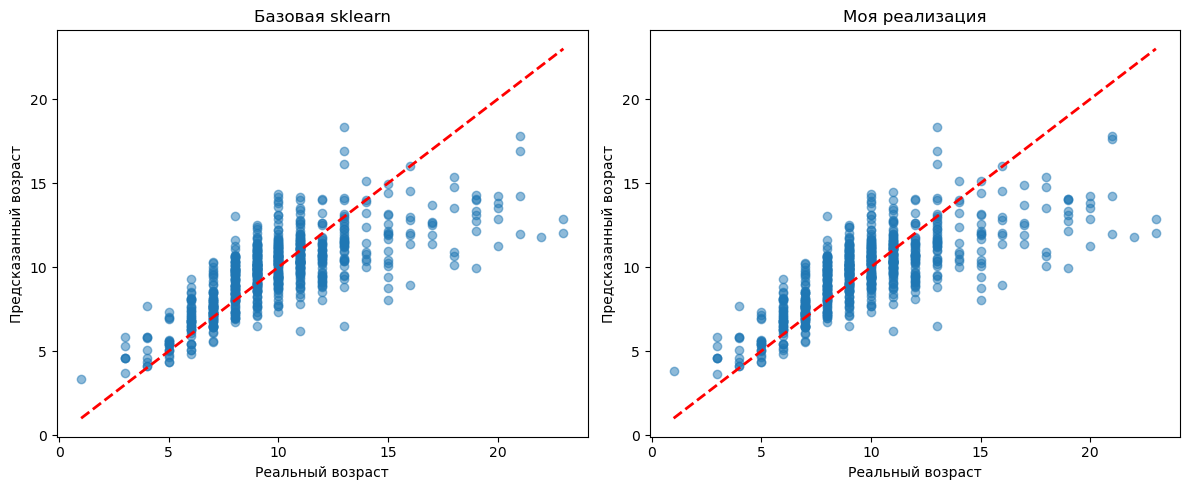

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_r, preds_reg_gb, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Базовая sklearn')

plt.subplot(1, 2, 2)
plt.scatter(y_test_r, preds_custom_gb_reg, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Моя реализация')
plt.tight_layout()
plt.show()

Точки на обоих графиках плотно группируются вокруг диагональной линии. Визуально разница между моделями почти вина, моя модель воспроизвела поведение библиотечной версии практически идеально. Это значит, что алгоритм был реализован правильно и логично без существенных численных ошибок или нестабильности. Таким образом, моя реализация градиентного бустинга успешно справилась с задачей регрессии. Она продемонстрировала небольшое улучшение качества, что можно объяснить более простой и стабильной архитектурой, которая лучше справляется с шумом в данных.

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [67]:
df_r = pd.read_csv('CrabAgePrediction.csv')

df_r = df_r.drop(['Length', 'Diameter', 'Height'], axis=1)
le_sex = LabelEncoder()

df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42
)

Я загрузила датасет, удалила сильно коррелирующие признаки Length, Diameter и Height, закодировала категориальный признак Sex с помощью LabelEncoder, удалила исходный столбец и разделила данные на обучающую и тестовую выборки с фиксированным random_state=42, как в пункте 2

In [68]:
custom_gb_reg_imp = MyGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
custom_gb_reg_imp.fit(X_train_r, y_train_r)
preds_custom_imp = custom_gb_reg_imp.predict(X_test_r)

mae_custom_imp = mean_absolute_error(y_test_r, preds_custom_imp)
rmse_custom_imp = np.sqrt(mean_squared_error(y_test_r, preds_custom_imp))
r2_custom_imp = r2_score(y_test_r, preds_custom_imp)

Я обучила свою улучшенную модель градиентного бустинга на данных без коррелирующих признаков, используя базовые гиперпараметры. Сделала предсказания и вычислила метрики.

In [69]:
print(f"Улучшенная модель sklearn:")
print(f"  MAE: {metrics_reg_gb_h1['mae']:.4f}")
print(f"  RMSE: {metrics_reg_gb_h1['rmse']:.4f}")
print(f"  R2: {metrics_reg_gb_h1['r2']:.4f}")

print(f"\nМоя улучшенная модель:")
print(f"  MAE: {mae_custom_imp:.4f}")
print(f"  RMSE: {rmse_custom_imp:.4f}")
print(f"  R2: {r2_custom_imp:.4f}")

print(f"\nРазница:")
print(f"  MAE: {mae_custom_imp - metrics_reg_gb_h1['mae']:+.4f}")
print(f"  RMSE: {rmse_custom_imp - metrics_reg_gb_h1['rmse']:+.4f}")
print(f"  R2: {r2_custom_imp - metrics_reg_gb_h1['r2']:+.4f}")

Улучшенная модель sklearn:
  MAE: 1.4774
  RMSE: 2.0937
  R2: 0.5438

Моя улучшенная модель:
  MAE: 1.4770
  RMSE: 2.0959
  R2: 0.5429

Разница:
  MAE: -0.0004
  RMSE: +0.0022
  R2: -0.0009


Моя улучшенная реализация градиентного бустинга для регрессии показала качество, практически идентичное улучшенной модели из sklearn. Разница в метриках минимальна, MAE отличается на -0.0004 месяца, RMSE на +0.0022, а R2 на -0.0009. Моя модель практически эквивалентна модели из библиотеки

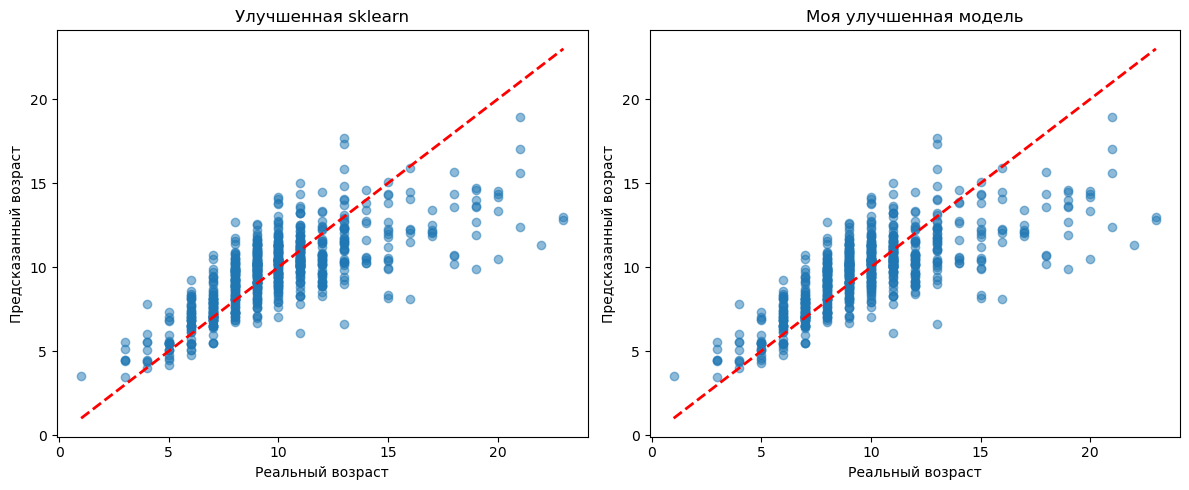

In [71]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_r, preds_h1, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.title('Улучшенная sklearn')
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')

plt.subplot(1, 2, 2)
plt.scatter(y_test_r, preds_custom_imp, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.title('Моя улучшенная модель')
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.tight_layout()
plt.show()